# Прототип модели предсказания коэффициента восстановления золота из золотосодержащей руды

Модель предсказания коэффициента восстановления золота из золотосодержащей руды. В распоряжении данные с параметрами добычи и очистки. 


## 1. Загрузка и подготовка данных

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor

pd.options.display.max_columns = None

### 1.1 Обзор файлов

In [152]:
# Данные индексируются датой и временем получения информации (признак date)
# train.date.nunique(), test.date.nunique() показали, что значения уникальны
train = pd.read_csv('gold_recovery_train_new.csv', index_col='date', parse_dates=True)
test = pd.read_csv('gold_recovery_test_new.csv', index_col='date', parse_dates=True)
full = pd.read_csv('gold_recovery_full_new.csv', index_col='date', parse_dates=True)


In [153]:
print(f'Размерность датасета train:', train.shape)
print(f'Размерность датасета test:', test.shape)
print(f'Размерность датасета full:', full.shape)

Размерность датасета train: (14149, 86)
Размерность датасета test: (5290, 52)
Размерность датасета full: (19439, 86)


In [154]:
full.head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.

In [155]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14149 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         14148 non-null  float64
 1   final.output.concentrate_pb                         14148 non-null  float64
 2   final.output.concentrate_sol                        13938 non-null  float64
 3   final.output.concentrate_au                         14149 non-null  float64
 4   final.output.recovery                               14149 non-null  float64
 5   final.output.tail_ag                                14149 non-null  float64
 6   final.output.tail_pb                                14049 non-null  float64
 7   final.output.tail_sol                               14144 non-null  float64
 8   final.output.tail_au                     

In [156]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5290 entries, 2016-09-01 00:59:59 to 2017-12-31 23:59:59
Data columns (total 52 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5286 non-null   float64
 1   primary_cleaner.input.depressant            5285 non-null   float64
 2   primary_cleaner.input.feed_size             5290 non-null   float64
 3   primary_cleaner.input.xanthate              5286 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5290 

In [157]:
full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19439 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         19438 non-null  float64
 1   final.output.concentrate_pb                         19438 non-null  float64
 2   final.output.concentrate_sol                        19228 non-null  float64
 3   final.output.concentrate_au                         19439 non-null  float64
 4   final.output.recovery                               19439 non-null  float64
 5   final.output.tail_ag                                19438 non-null  float64
 6   final.output.tail_pb                                19338 non-null  float64
 7   final.output.tail_sol                               19433 non-null  float64
 8   final.output.tail_au                     

Тип данных в столбцах датафреймов float, значит менять их не нужно.

In [158]:
train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,14117.000000,14149.000000,14049.000000,14149.000000,14063.000000,13863.000000,14149.000000,14148.000000,14134.000000,14103.000000,14149.000000,14145.000000,14148.000000,14145.000000,14148.000000,14147.000000,14148.000000,14146.000000,14148.000000,1.414800e+04,14148.000000,14148.000000,14149.000000,14149.000000,14049.000000,14141.000000,14005.000000,14071.000000,14149.000000,14120.000000,14141.000000,14113.000000,13721.000000,14149.000000,14149.000000,14127.000000,14149.000000,14149.000000,14148.000000,14149.000000,14149.000000,14149.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14149.000000,14149.000000,13713.000000,14149.000000,14149.000000,14149.000000,14147.000000,14139.000000,12544.000000,14149.000000,13932.000000,14148.000000,14128.000000,14148.000000,14145.000000,14148.000000,14148.000000,14148.000000,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148

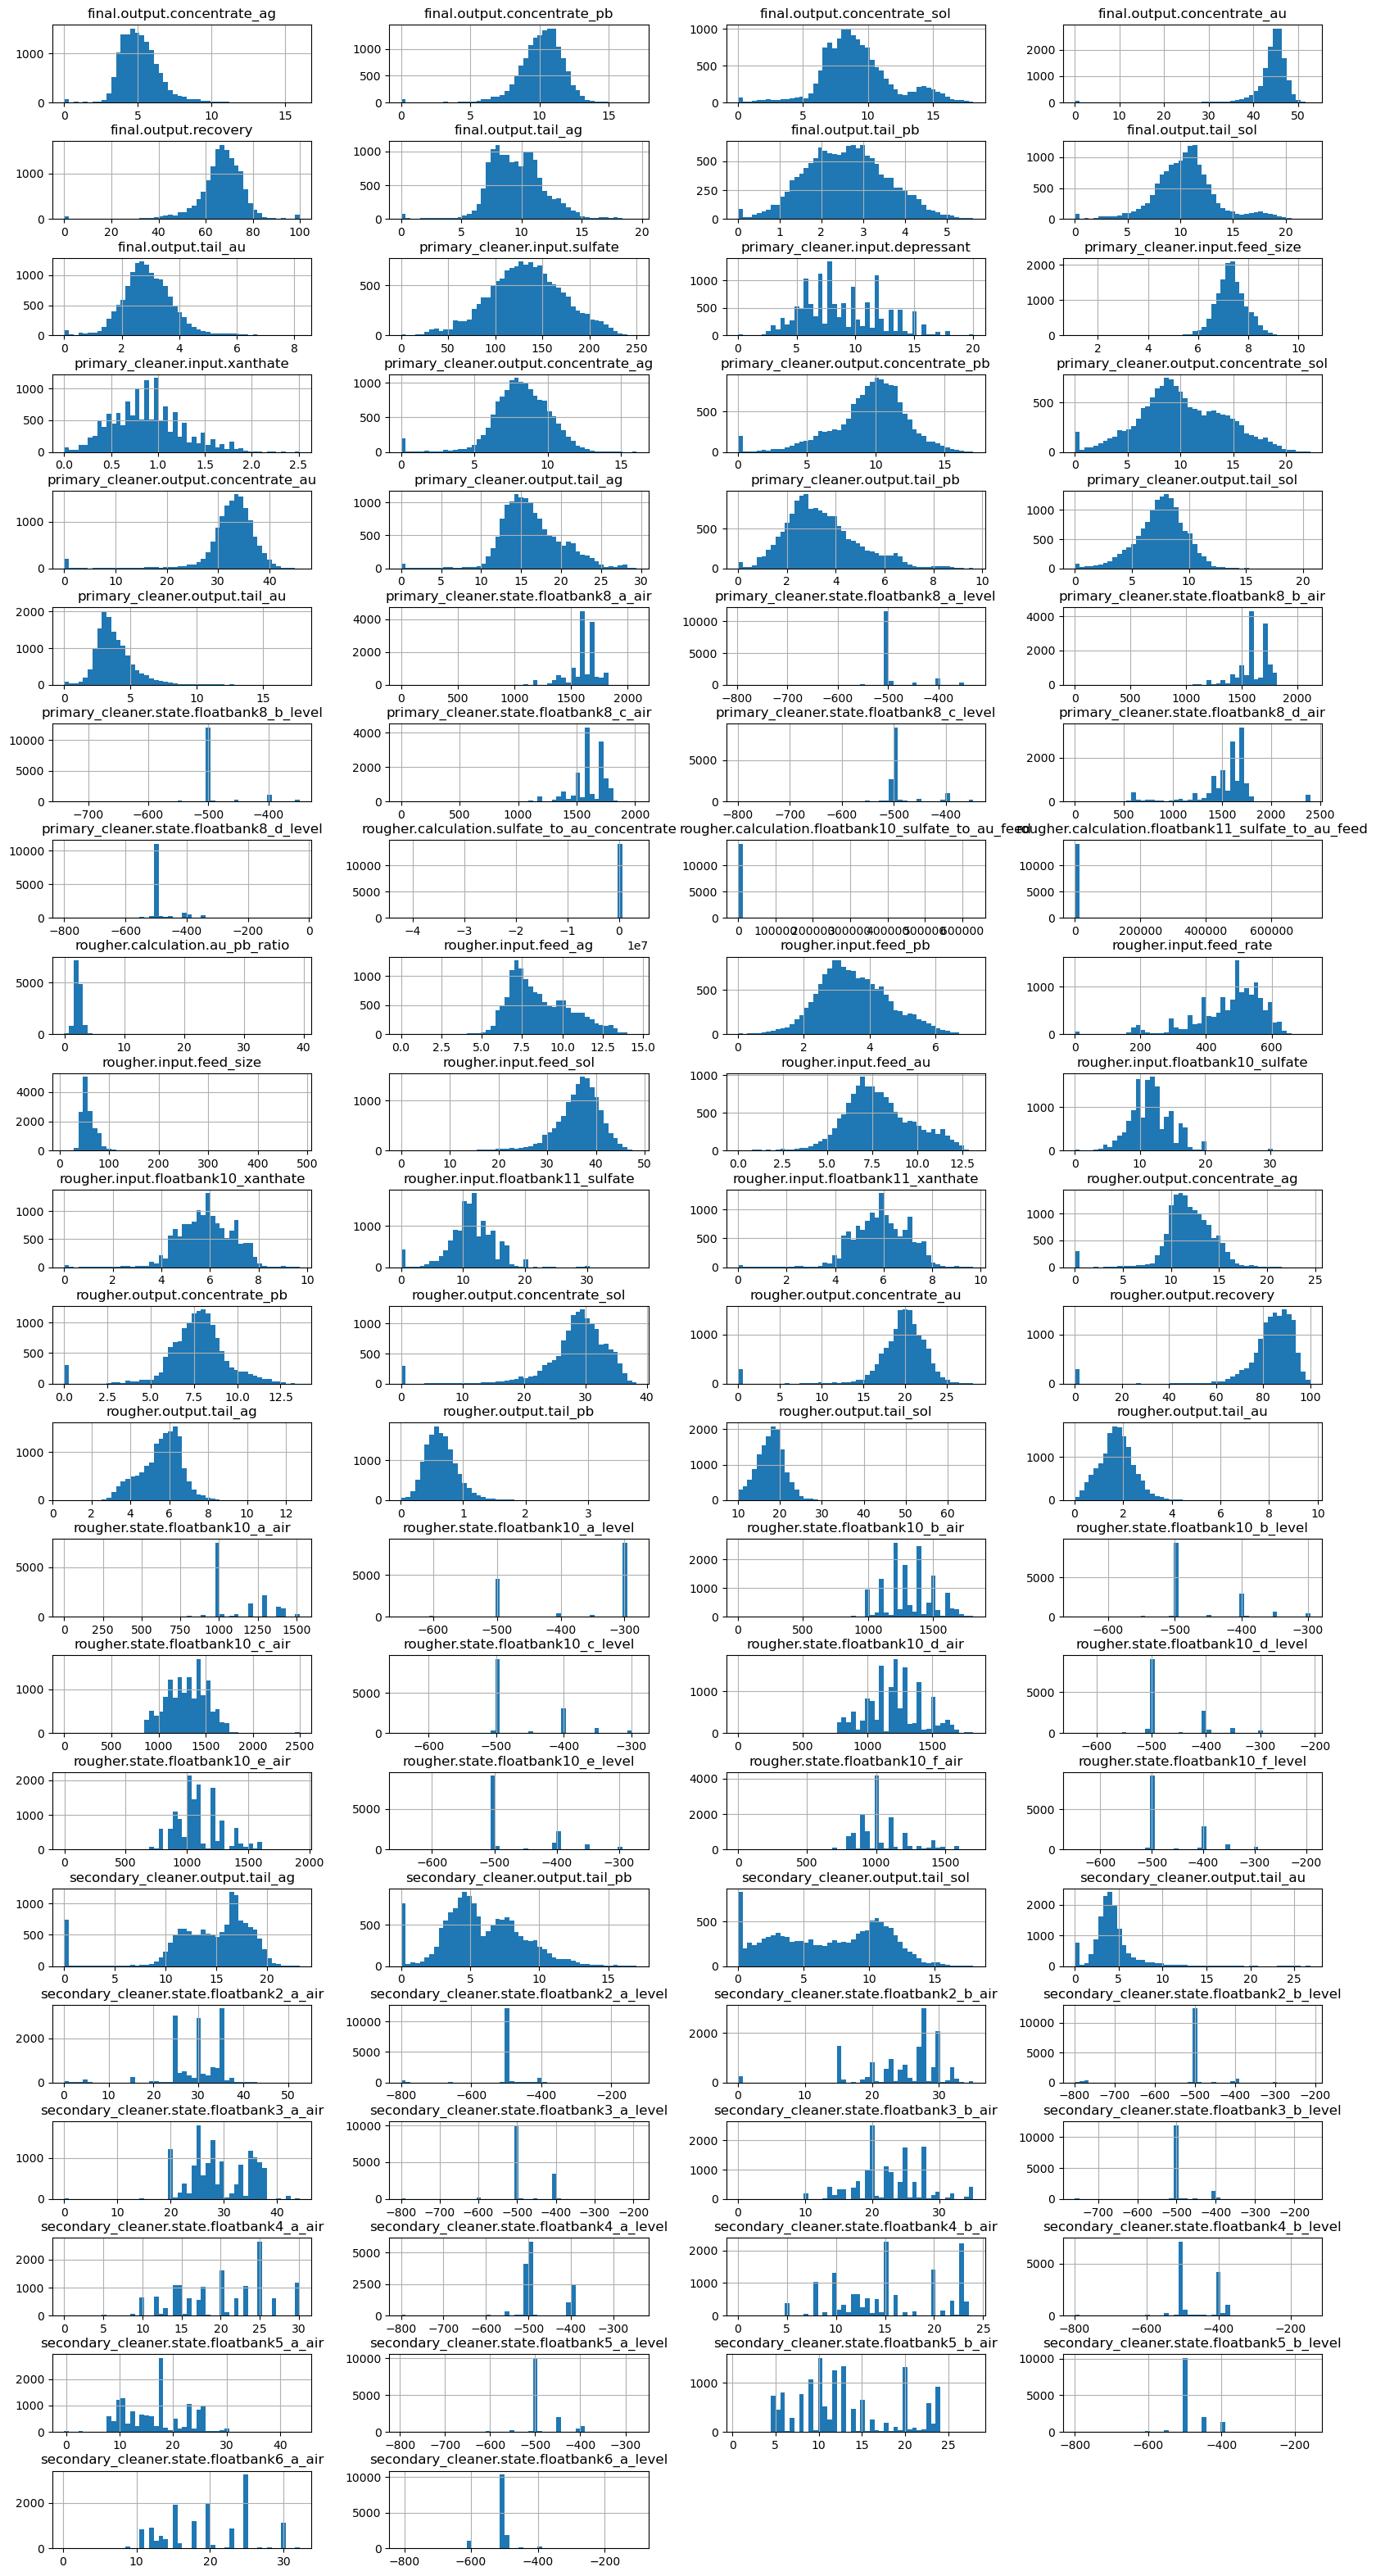

In [159]:
train.hist(figsize=(20, 40), layout=(22, 4), bins=50)
plt.subplots_adjust(hspace=0.5);

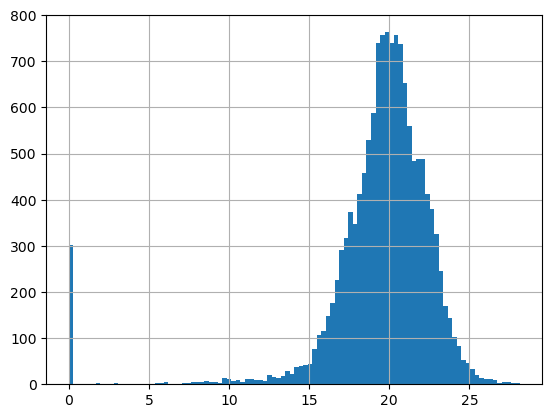

In [160]:
# Имеются странные выбросы (около нуля) в некоторых столцах, например, в rougher.output.concentrate_au
train['rougher.output.concentrate_au'].hist(bins=100);

In [161]:
# исследуем нулевые значения в столбце
train['rougher.output.concentrate_au'].describe()

count    14149.000000
mean        19.439958
std          3.765192
min          0.000000
25%         18.432161
50%         19.947312
75%         21.392714
max         28.146838
Name: rougher.output.concentrate_au, dtype: float64

In [162]:
train[train['rougher.output.concentrate_au'] == 0]['rougher.output.concentrate_au'].count()

297

In [163]:
train[train['rougher.output.concentrate_au'] == 0].head()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-16 21:00:00,4.566664,10.406178,4.588698,46.614456,68.403877,10.705777,1.509070,17.875134,2.509776,131.251366,13.969457,7.25,1.203034,8.513177,9.724797,19.120964,37.633572,16.455383,3.366501,6.864404,3.434734,1601.674776,-500.285160,1600.151967,-499.633542,1599.542959,-499.495721,1599.342687,-500.360306,41359.061159,3196.130244,3205.717062,2.530283,7.521974,2.811569,581.605260,65.620714,41.154430,7.114065,13.322740,7.504592,13.311361,7.493738,0.0,0.0,0.0,0.0,0.0,4.784398,0.818965,20.046797,1.939811,999.026619,-499.850895,1600.614880,-500.331775,1598.654561,-500.364377,1398.394100,-501.540155,1197.182011,-500.205806,1198.542180,-499.648335,13.605154,4.983564,9.545239,3.102137,25.963860,-498.097243,23.896954,-500.047419,24.963926,-500.207267,23.984937,-500.613261,14.025588,-550.404242,12.028925,-550.570104,10.052072,-500.797905,7.984500,-499.581046,11.982025,-599.161228
2016-01-16 22:00:00,4.577832,10.691605,5.274175,46.250638,70.675633,10.728531,1.641216,18.349339,2

В итоге, довольно много значений с нулем, также, в некоторых столбах есть отрицательные значения, например, в secondary_cleaner.state.floatbank6_a_level. Возможно, так настроен технический процесс, ничего с этим мы делать не будем)

### 1.2. Проверка расчета эффективности обогащения 

In [164]:
# функция рассчета эффективности
def recovery(c, f, t):
    return (c * (f - t))/(f * (c - t)) * 100

# посчитаем эффективность для признака rougher.output.recovery в датасете train
rougher_recovery = recovery(train['rougher.output.concentrate_au'],
                            train['rougher.input.feed_au'],
                            train['rougher.output.tail_au'])

rougher_recovery_mae = mean_absolute_error(train['rougher.output.recovery'], rougher_recovery)
print('MAE между расчётным и предложенным значением признака rougher.output.recovery', rougher_recovery_mae)
print('Медиана по столбцу rougher.output.recovery', train['rougher.output.recovery'].median())
print('Медиана по расчетному столбцу recovery', rougher_recovery.median())

MAE между расчётным и предложенным значением признака rougher.output.recovery 9.73512347450521e-15
Медиана по столбцу rougher.output.recovery 85.2994620986978
Медиана по расчетному столбцу recovery 85.29946209869779


In [165]:
# данная в датасете rougher.output.recovery 
train['rougher.output.recovery'].median()

85.2994620986978

In [166]:
# рассчитаная нами
rougher_recovery.median()

85.29946209869779

Значение MAE между расчётным и предложенным rougher.output.recovery равно 9.73512347450521e-15, что ничтожно мало и можно списать на ошибки округления. 

### 1.3. Анализ признаков, недоступных в тестовой выборке

In [167]:
# Список признаков, недоступных в тествой выборке
list(train.columns.difference(test.columns))

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

In [168]:
# Проверка
len(list(train.columns.difference(test.columns)))

34

Это признаки с типом параметра output, то что мы получаем на выходе. Данные признаки прямо или косвенно используются для расчета коэфициента эффективности, поэтому были удалены.

Для корректного обучения модели на тренировочном датасете, нам нужно убрать столбцы из шага выше. Иными словами, оставить только те столбцы обущающего датасета, которые есть в тестовом. Также выделим в отдельный датасет столбцы rougher.output.recovery и final.output.recovery для обучения и оценки моделей. Эти шаги сделаем после предобратки данных. 

### 1.4. Предобработка данных

In [169]:
# проверим дубликаты
train.duplicated().sum()

0

In [170]:
test.duplicated().sum()

0

In [171]:
# проверим отсутствующие значения
train.isnull().sum()

final.output.concentrate_ag                     1
final.output.concentrate_pb                     1
final.output.concentrate_sol                  211
final.output.concentrate_au                     0
final.output.recovery                           0
                                             ... 
secondary_cleaner.state.floatbank5_a_level      1
secondary_cleaner.state.floatbank5_b_air        1
secondary_cleaner.state.floatbank5_b_level      1
secondary_cleaner.state.floatbank6_a_air        2
secondary_cleaner.state.floatbank6_a_level      1
Length: 86, dtype: int64

In [172]:
test.isnull().sum()

primary_cleaner.input.sulfate                  4
primary_cleaner.input.depressant               5
primary_cleaner.input.feed_size                0
primary_cleaner.input.xanthate                 4
primary_cleaner.state.floatbank8_a_air         0
primary_cleaner.state.floatbank8_a_level       0
primary_cleaner.state.floatbank8_b_air         0
primary_cleaner.state.floatbank8_b_level       0
primary_cleaner.state.floatbank8_c_air         0
primary_cleaner.state.floatbank8_c_level       0
primary_cleaner.state.floatbank8_d_air         0
primary_cleaner.state.floatbank8_d_level       0
rougher.input.feed_ag                          0
rougher.input.feed_pb                          0
rougher.input.feed_rate                        3
rougher.input.feed_size                        1
rougher.input.feed_sol                        21
rougher.input.feed_au                          0
rougher.input.floatbank10_sulfate              5
rougher.input.floatbank10_xanthate             0
rougher.input.floatb

In [173]:
# также убедимся, что в целевых столбцах нет пропущенных значений
train.loc[:, ['rougher.output.recovery', 'final.output.recovery']].isnull().sum()

rougher.output.recovery    0
final.output.recovery      0
dtype: int64

In [174]:
train.isnull().sum().count()/train.shape[0]

0.006078168068414729

Всего меньше 0.4% строк с отсутствующими значениями во всем датасете. Можно их удалить, но т.к. это временной ряд, лучше интерполируем их методом interpolate с параметром linear:

In [175]:
# Заполним отсутствующие значения методом interpolate
train.interpolate(inplace=True)
test.interpolate(inplace=True)

In [176]:
train.isnull().sum()

final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
final.output.recovery                         0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 86, dtype: int64

In [177]:
# Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. 
# Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. 
# Оставим в обучающем датасете только те столбцы, которые есть в тестовом
features_train = train.loc[:, test.columns]
# Выделим целевые признаки в обучающем датасете
target_train = train.loc[:, ['rougher.output.recovery', 'final.output.recovery']]

Посмотрим на корреляцию признаков

In [178]:
corr_matrix = train.corr()
corr_matrix

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
final.output.concentrate_ag,1.000000,0.021192,0.314380,-0.104636,0.133254,0.289609,-0.109430,0.046074,0.193927,0.015008,0.136818,0.024982,0.167695,0.502801,-0.178736,0.306531,-0.186005,-0.001376,-0.066408,0.161469,0.191251,0.188473,0.041941,0.203532,0.053561,0.165960,0.043283,0.098210,0.007246,-0.016920,-0.027784,-0.037687,0.195324,0.424454,-0.005001,-0.177190,-0.018795,-0.047342,0.276674,-0.118209,0.069094,-0.143620,0.041617,0.288791,-0.167323,-0.041978,0.033207,0.037963,0.191791,-0.032421,0.022972,0.131940,0.115860,-0.188730,0.120134,0.084064,0.099670,0.088060,0.129469,0.083695,0.171411,0.100890,0.154032,0.097247,-0.080093,-0.309389,0.192984,0.044342,-0.067907,0.036821,-0.026850,0.039355,0.054256,0.180709,0.027876,0.208831,0.043438,0.169569,0.020942,0.005372,0.013105,0.228848,0.021732,0.199144,0.170383,0.061009
final.output.concentrate_pb,0.021192,1.000000,-0.001077,0.321012,0.095015,-0.100543,0.259453,0.068423,0.029186,0.116694,0.013790,-0.051195,-0.180665,-0.031335,0.388771,-0.065978,0.008713,-0.042597,0.003483,-0.017159,-0.127716,-0.023526,0.062417,-0.0430

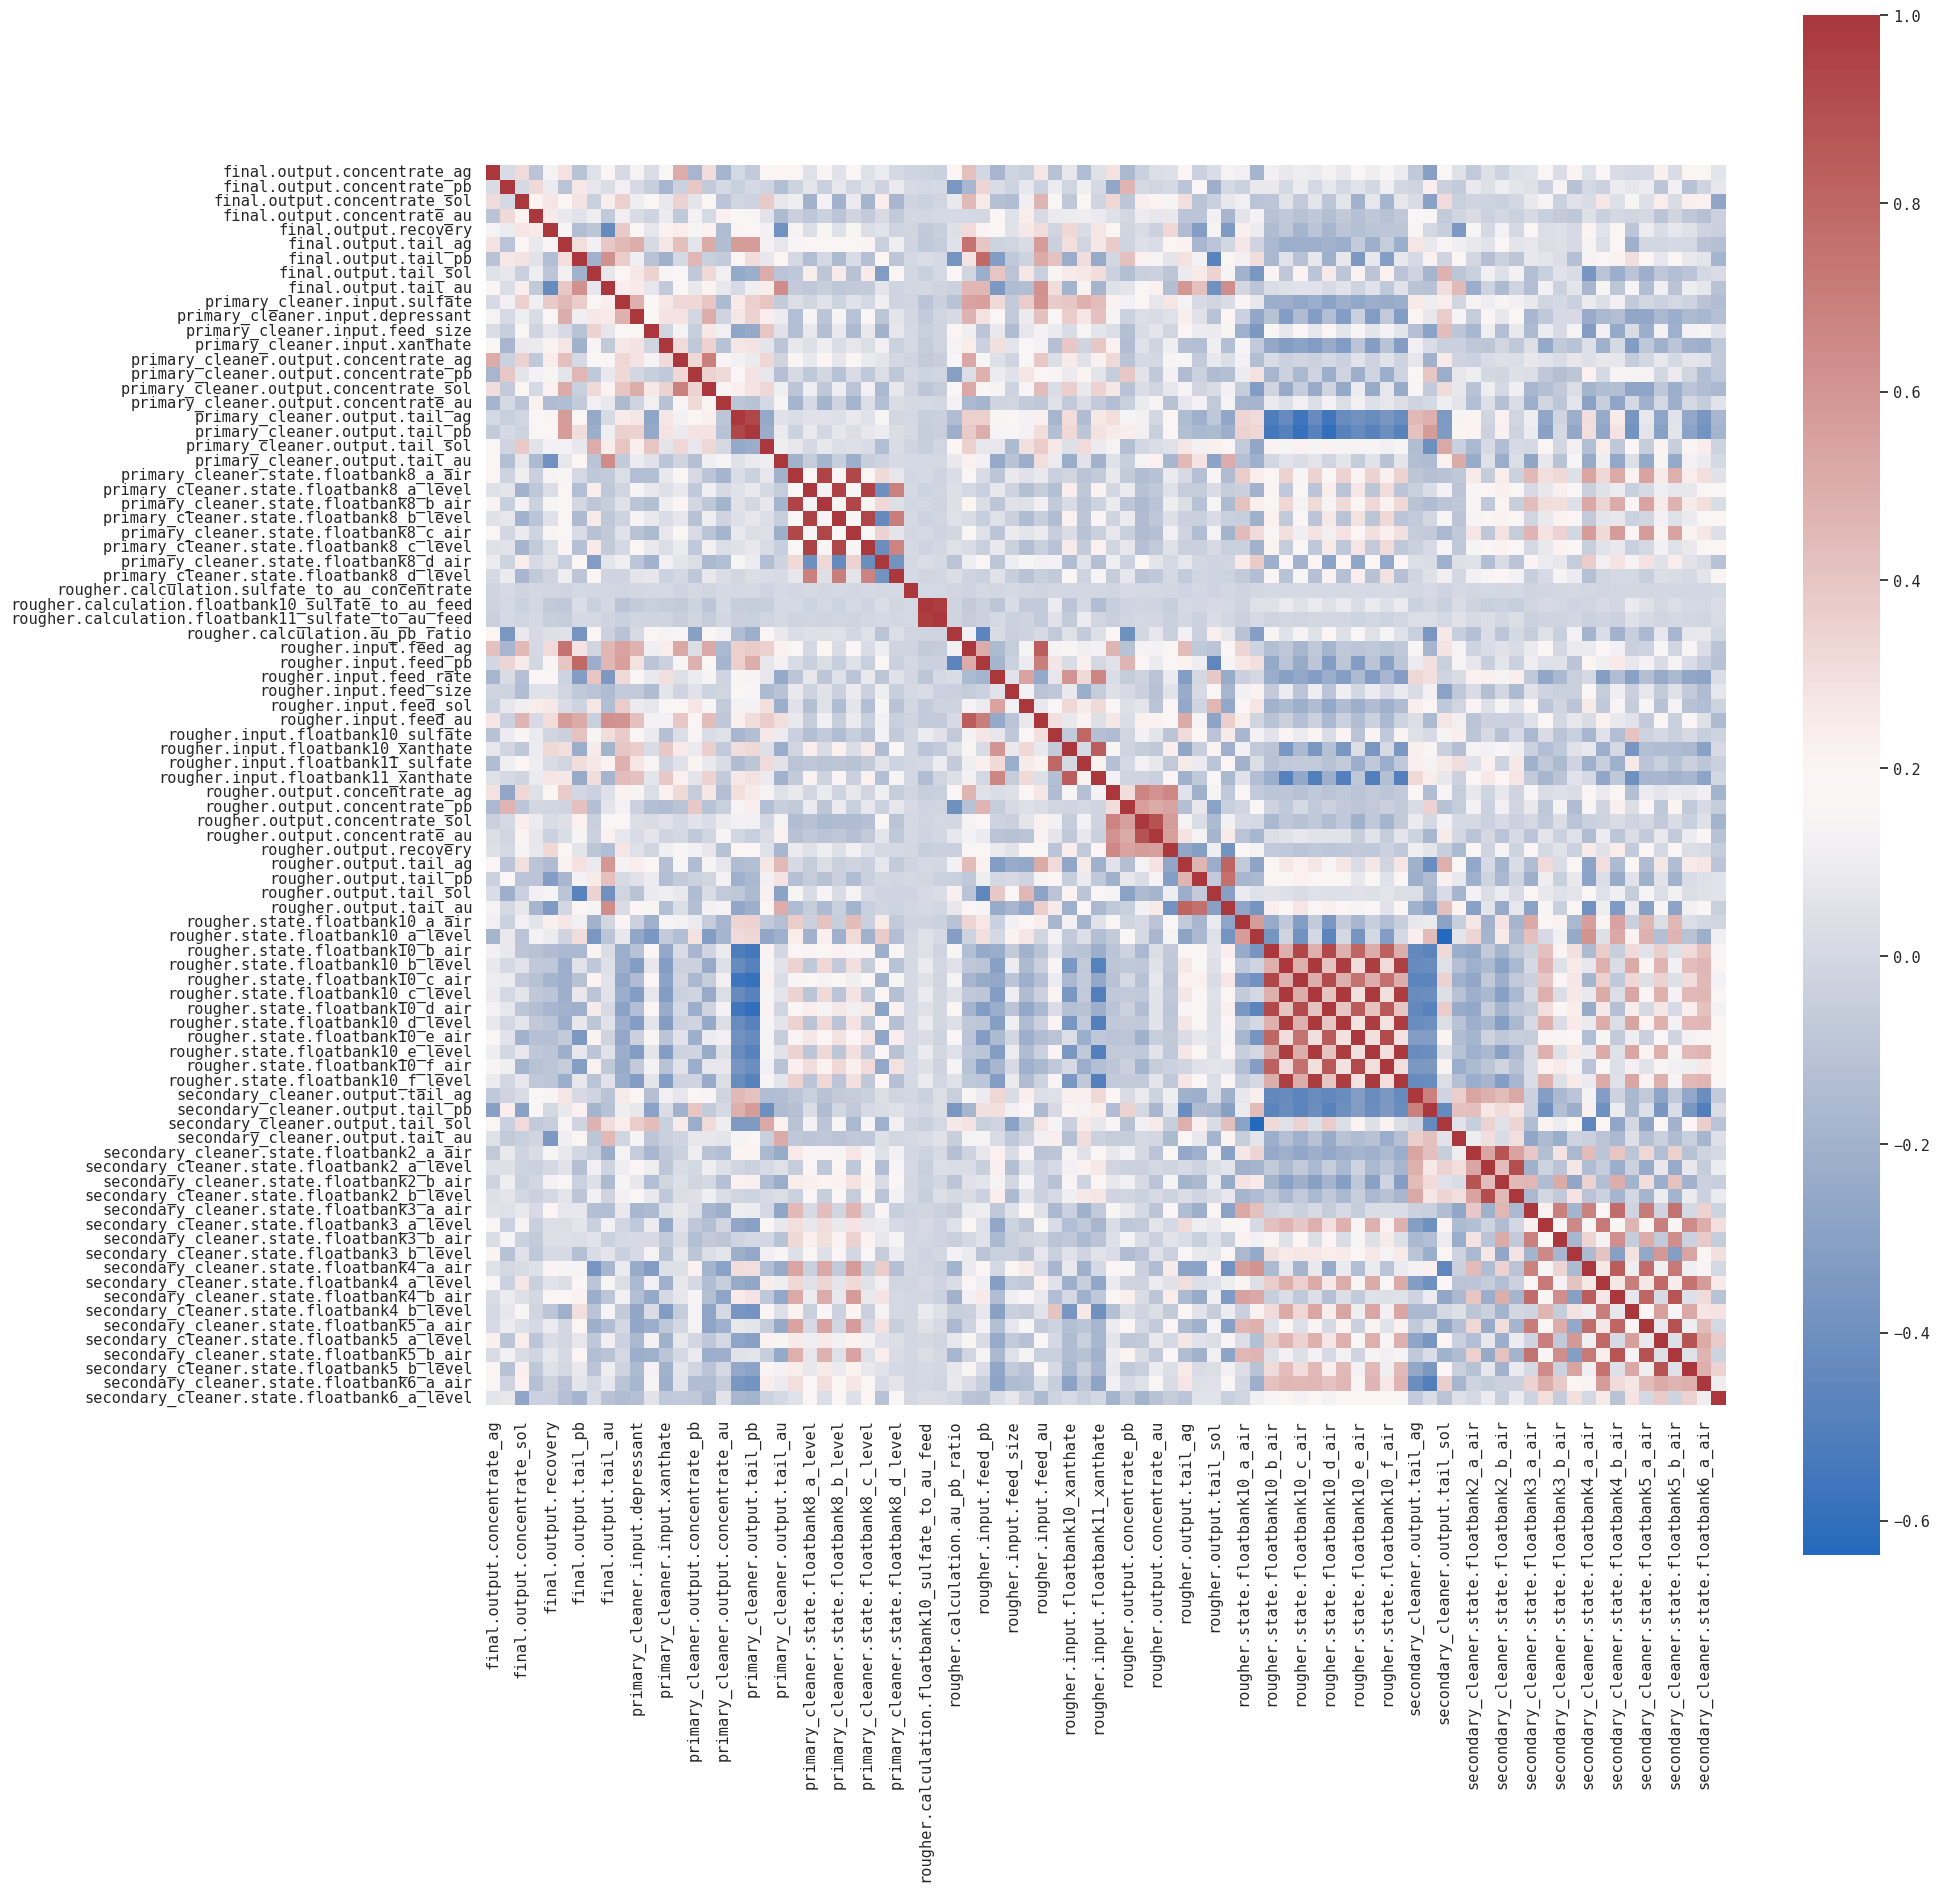

In [179]:
# Изобразим это на графиках
sns.set(context="notebook", font="monospace", rc={'figure.figsize':(20, 20)})
#sns.heatmap(corr_matrix, square=True, cmap='vlag', xticklabels=False , yticklabels=False)
sns.heatmap(corr_matrix, square=True, cmap='vlag')

plt.show()


Из таблицы и по графику мы видим, что есть определенные признаки сильно коррелирующие друг с другом (коэфициент корреляции > 0.9), например, такие признаки как primary_cleaner.state.floatbank_b_air и primary_cleaner.state.floatbank_a_air, т.е. признаки, характеризиющие различные параметры состояния. В результате, нам будет сложно оценить влияние высококоррелирующих параметров на целевой признак, но на данном этапе у нас нет такой задачи, поэтому будем просто иметь это в виду. 

Так как при построении моделей мы будем использовать в то числе модель линейной регрессии, масштабируем признаки:

In [180]:
pd.options.mode.chained_assignment = None

scaler = StandardScaler()
scaler.fit(features_train)

features_train_scaled = scaler.transform(features_train)
test_scaled = scaler.transform(test)

Вывод

Мы проверили датасет на наличие дубликатов, также заполнили отсутствующие значения методом интерполяции. Разбили обучающий датасет на признаки и таргет. Далее, посторили матрицу корреляции и отобразили ее на графике тепловой карты: есть определенные признаки сильно коррелирующие друг с другом (коэфициент корреляции > 0.9), например, такие признаки как primary_cleaner.state.floatbank_b_air и primary_cleaner.state.floatbank_a_air, т.е. признаки, характеризиющие различные параметры состояния. В результате, нам будет сложно оценить влияние высококоррелирующих параметров на целевой признак, но на данном этапе у нас нет такой задачи, поэтому будем просто иметь это в виду. В конце мы масшатабировли количественные признаки в обучающем и тестовом датасетах для моделей линейной регрессии.

## Анализ данных

### 2.1. Анализ изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки

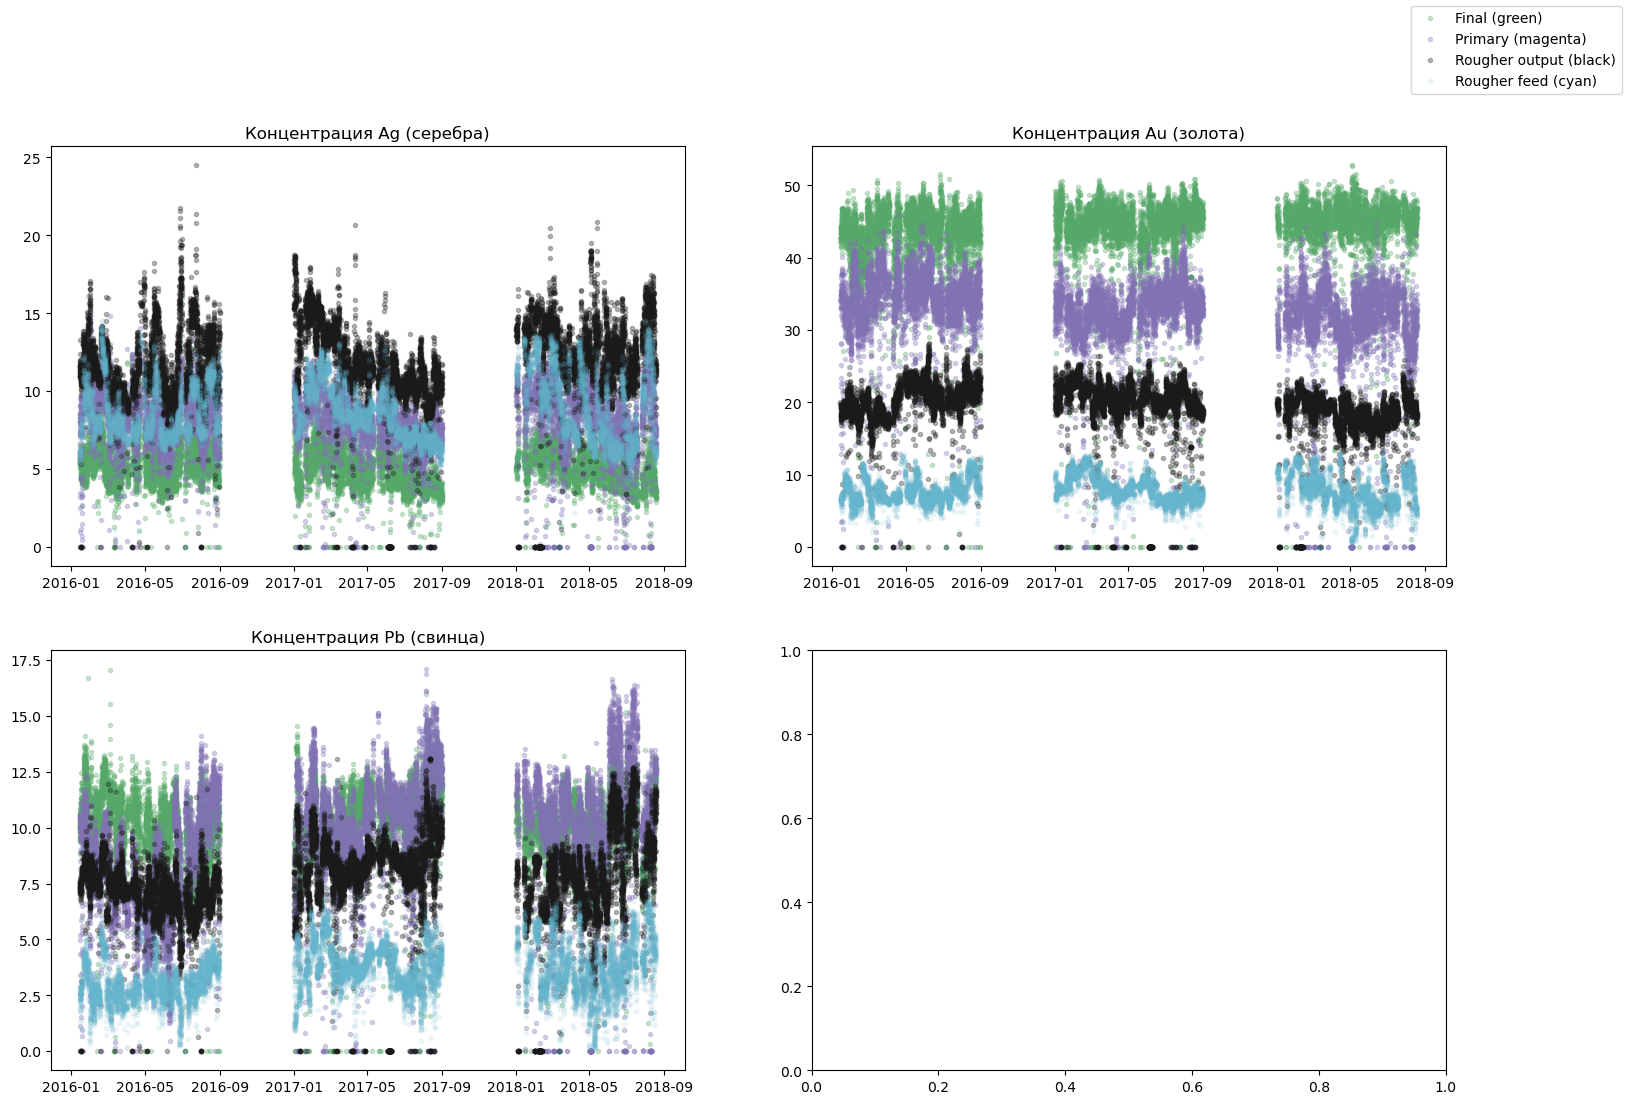

In [181]:
# Au, Ag, Pb
plt.style.use('default')
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(18, 12))

axs[0, 0].plot(train['final.output.concentrate_ag'], 'g.', label='Final (green)', alpha=0.3)
axs[0, 0].plot(train['primary_cleaner.output.concentrate_ag'], 'm.', label='Primary (magenta)', alpha=0.3)
axs[0, 0].plot(train['rougher.output.concentrate_ag'], 'k.', label='Rougher output (black)', alpha=0.3)
axs[0, 0].plot(train['rougher.input.feed_ag'], 'c.', label='Rougher feed (cyan)', alpha=0.1)
axs[0,0].set_title('Концентрация Ag (серебра)')

axs[0, 1].plot(train['final.output.concentrate_au'], 'g.', alpha=0.3)
axs[0, 1].plot(train['primary_cleaner.output.concentrate_au'], 'm.', alpha=0.3)
axs[0, 1].plot(train['rougher.output.concentrate_au'], 'k.', alpha=0.3)
axs[0, 1].plot(train['rougher.input.feed_au'], 'c.', alpha=0.1)
axs[0,1].set_title('Концентрация Au (золота)')

axs[1, 0].plot(train['final.output.concentrate_pb'], 'g.', alpha=0.3)
axs[1, 0].plot(train['primary_cleaner.output.concentrate_pb'], 'm.', alpha=0.3)
axs[1, 0].plot(train['rougher.output.concentrate_pb'], 'k.', alpha=0.3)
axs[1, 0].plot(train['rougher.input.feed_pb'], 'c.', alpha=0.1)
axs[1,0].set_title('Концентрация Pb (свинца)')

fig.legend()

plt.show()

По графикам видим, что концентрация золота ожидаемо повышается в зависимости от стадии обработки руды, самая низкая концентрация в черновой руде на входе (на графиках - голубой (cyan) цвет), больше на стадии первичной обработки (на графиках - пурпурный цвет), и больше всего на финальной стадии - показано зеленым цветом. Концентрация свинца в руде от черновой руды к фиальной лишь отчасти коррелирует с концентрацией золота, а концентрация серебра, наоборот, понижается. 

### 2.2. Сравние распределения размеров гранул сырья на обучающей и тестовой выборках

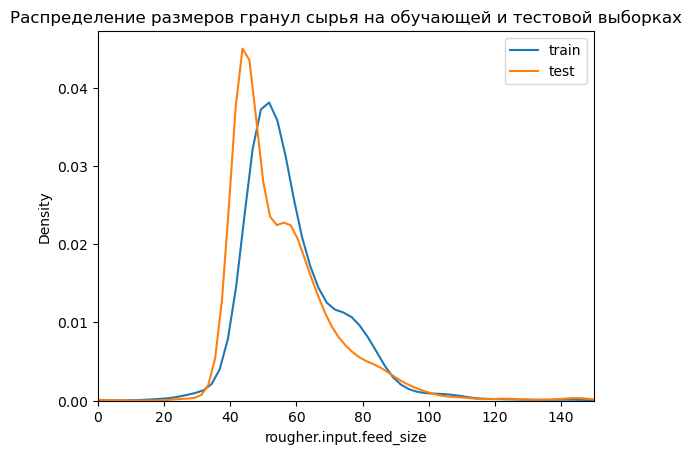

In [182]:
fig, ax = plt.subplots()
sns.kdeplot(data=train, x="rougher.input.feed_size", label='train')
sns.kdeplot(data=test, x="rougher.input.feed_size", label='test')
plt.xlim([0,150])
plt.legend()
plt.title('Распределение размеров гранул сырья на обучающей и тестовой выборках')
plt.show()

Эмпирически, можно сделалать вывод, что распределения размеров гранул сырья на обучающей и тестовой выборках похожи. Соответственно, оценка модели будет корректной. 

### 2.3. Исследование суммарной концентрации веществ на разных стадиях

In [183]:
def calculate_element_amount(df, stage):
    if stage == 'rougher.input.':
        elements = ['feed_ag', 'feed_pb', 'feed_sol', 'feed_au']
    else:
        elements = ['concentrate_ag', 'concentrate_pb', 'concentrate_sol', 'concentrate_au']
    amount = 0
    for element in elements:
        amount += df[stage+element]
    #  Удалим выбросы т.е. если суммарное значение близко к нулю
    df.drop(amount[amount < 1].index, inplace=True) # в train датсете
    amount.drop(amount[amount < 1].index, inplace=True) # в датсете для вывода графиков
    
    return amount

final_sum = calculate_element_amount(train, 'final.output.')
primary_cleaner_sum = calculate_element_amount(train, 'primary_cleaner.output.')
rougher_output_sum = calculate_element_amount(train, 'rougher.output.')
rougher_input_sum = calculate_element_amount(train, 'rougher.input.')

In [184]:
# сколько осталось строк после удаления выбросов по суммарной концентрации веществ
train.shape

(13599, 86)

In [185]:
# Обновим features_train, target_train
features_train = train.loc[:, test.columns]
# Выделим целевые признаки в обучающем датасете
target_train = train.loc[:, ['rougher.output.recovery', 'final.output.recovery']]

# Обновим scaler
scaler = StandardScaler()
scaler.fit(features_train)

features_train_scaled = scaler.transform(features_train)
test_scaled = scaler.transform(test)

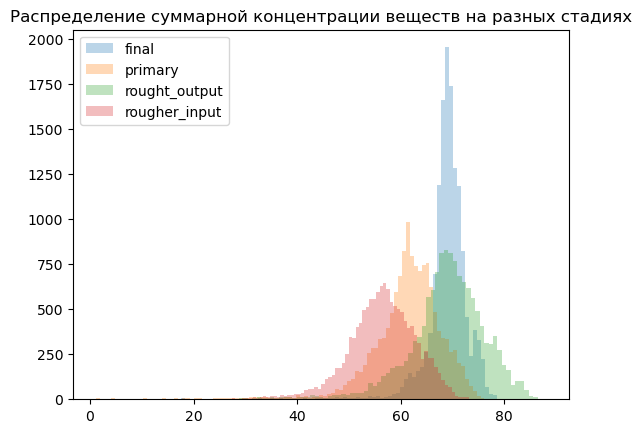

In [186]:
fig, ax = plt.subplots()

ax.hist(final_sum, bins=100, label='final', alpha=0.3)
ax.hist(primary_cleaner_sum, bins=100, label='primary', alpha=0.3)
ax.hist(rougher_output_sum, bins=100, label='rought_output', alpha=0.3)
ax.hist(rougher_input_sum, bins=100, label='rougher_input', alpha=0.3)

plt.legend()
plt.title('Распределение суммарной концентрации веществ на разных стадиях')
plt.show()

Из графика видно, что суммарная концентрация наблюдаемых веществ (Au, Ag, Pb, Sul) самых восоких значений достигает на финальной стадии, практически 2000, также на этой стадии наименьшая дисперсия. Наименьшие значения распределения суммарной концентрации в исходном сырье и, максимум, составляет 750 (грамм на тонну?).

## Модель

### 3.1.  Функция для вычисления итоговой sMAPE

In [187]:
def SMAPE(train, test):
    result = (np.sum(np.abs(train - test)/((np.abs(train) + np.abs(test))/2)/len(train))) * 100
    return result

def FINAL_SMAPE(rougher, final):
    return (0.25*rougher + 0.75*final)

### 3.2. Обучение моделей и оценка их качества

In [188]:
# функцию make_scorer мы не изучали в Практикуме, наставник подсказал
smape_score = make_scorer(SMAPE, greater_is_better=False)
STATE = 12345

*Linear Regression*

In [189]:
model = LinearRegression()
model.fit(features_train_scaled, target_train['rougher.output.recovery'])

scores = cross_val_score(model, features_train_scaled, target_train['rougher.output.recovery'], cv=5, scoring=smape_score)

rougher_score = -scores.mean()
print('Linear Regressor Model sMAPE Rougher:', rougher_score)

Linear Regressor Model sMAPE Rougher: 7.2199161062275765


In [190]:
model = LinearRegression()
model.fit(features_train_scaled, target_train['final.output.recovery'])
scores = cross_val_score(model, features_train_scaled, target_train['final.output.recovery'], cv=5, scoring=smape_score)

final_score = -scores.mean()
print('Linear Regressor Model sMAPE Final:', final_score)

Linear Regressor Model sMAPE Final: 11.019253498925236


In [191]:
print('Итоговое sMAPE:', FINAL_SMAPE(rougher_score, final_score))

Итоговое sMAPE: 10.069419150750822


*Decision Tree*

In [192]:
param_grid = {"max_depth": np.arange(2, 12, 1), "min_samples_leaf": [1, 10, 30, 40, 50, 60]}

tree_rougher = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, scoring=smape_score)
tree_rougher.fit(features_train, target_train['rougher.output.recovery'])

rougher_score = -1*tree_rougher.best_score_
print('Decision Tree Model sMAPE rougher.output.recovery:', rougher_score)

Decision Tree Model sMAPE rougher.output.recovery: 6.81346051324155


In [193]:
tree_rougher.best_params_

{'max_depth': 3, 'min_samples_leaf': 1}

In [194]:
param_grid = {"max_depth": np.arange(2, 8, 1), "min_samples_leaf": [1, 30, 40, 50, 60]}

tree_final = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, scoring=smape_score, n_jobs=-1)
tree_final.fit(features_train, target_train['final.output.recovery'])

final_score = -1*tree_final.best_score_
print('Decision Tree Model sMAPE final.output.recovery:', final_score)

Decision Tree Model sMAPE final.output.recovery: 9.242601775169007


In [195]:
tree_final.best_params_

{'max_depth': 3, 'min_samples_leaf': 1}

In [196]:
print('Итоговое sMAPE:', FINAL_SMAPE(rougher_score, final_score))

Итоговое sMAPE: 8.635316459687143


*Random Forest*

In [197]:
param_grid = {'n_estimators': [10, 30, 40, 50, 100],
                  'max_depth': [1, 2, 3, 5, 7, 10, 12]}
rand_forest_rougher = GridSearchCV(RandomForestRegressor(n_jobs=-1, random_state=STATE), 
                           param_grid, 
                           cv=5, 
                           scoring=smape_score)

rand_forest_rougher.fit(features_train, target_train['rougher.output.recovery'])

rougher_score = -1*rand_forest_rougher.best_score_
print('Random Forest Model sMAPE rougher.output.recovery:', rougher_score)

Random Forest Model sMAPE rougher.output.recovery: 6.3932540606884825


In [198]:
rand_forest_rougher.best_params_

{'max_depth': 5, 'n_estimators': 50}

In [199]:
param_grid = {'n_estimators': [10, 20, 40, 50, 60],
                  'max_depth': [1, 2, 3, 5, 7, 10, 12]}
rand_forest_final = GridSearchCV(RandomForestRegressor(n_jobs=-1, random_state=STATE), 
                           param_grid, 
                           cv=5, 
                           scoring=smape_score)

rand_forest_final.fit(features_train, target_train['final.output.recovery'])

final_score = -1*rand_forest_final.best_score_
print('Random Forest Model sMAPE final.output.recovery:', final_score)

Random Forest Model sMAPE final.output.recovery: 9.04086020893227


In [200]:
rand_forest_final.best_params_

{'max_depth': 5, 'n_estimators': 50}

In [201]:
print('Итоговое sMAPE:', FINAL_SMAPE(rougher_score, final_score))

Итоговое sMAPE: 8.378958671871322


*Тестирование*

Итоговое sMAPE ниже всего получилось на Random Forest, поэтому используем эту модель:

In [202]:
# Посчитаем score (rougher) на тествой выборке
rougher_score = rand_forest_rougher.score(test, full.loc[test.index, 'rougher.output.recovery'].values)*-1
print('Random Forest roguher recovery score on the test set:', rougher_score)

Random Forest roguher recovery score on the test set: 8.120136455969192


In [203]:
final_score = rand_forest_final.score(test, full.loc[test.index, 'final.output.recovery'].values)*-1
print('Random Forest final recovery score on the test set:', final_score)

Random Forest final recovery score on the test set: 9.78141257991158


In [204]:
print('Итоговое sMAPE на тестовой выборке:', FINAL_SMAPE(rougher_score, final_score))

Итоговое sMAPE на тестовой выборке: 9.366093548925981


In [205]:
# Создадим базовую модель
# для чернового концентрата
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train['rougher.output.recovery'])
dummy_predict_rougher = dummy_regr.predict(test)

# для финального концентрата
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_train, target_train['final.output.recovery'])
dummy_predict_final = dummy_regr.predict(test)

dummy_score = FINAL_SMAPE(
    SMAPE(full.loc[test.index, 'rougher.output.recovery'].values, dummy_predict_rougher), 
    SMAPE(full.loc[test.index, 'final.output.recovery'].values, dummy_predict_final))
print('Итоговое sMAPE по базовой моделе на тествовой выборке:', dummy_score)

Итоговое sMAPE по базовой моделе на тествовой выборке: 9.832175134712106


Итоговое sMAPE по базовой моделе на тествовой выборке составило 9.83, что не так уж и выше чем на моделе Случайный лес, но все таки выше. 

Мы обучили три модели (Линейную регрессию, Дерево решений и Случайный лес) на обучающем датасете с перебором параметров и кросс-валидацией и вычислили на каждой моделе sMAPE для чернового концетрата и финального концетрата, а также вычислили итоговое значение sMAPE. Ниже всего итоговое sMAPE вышло на модели Случайный лес, поэтому эта модель была выбрана для тестирования. Итоговое sMAPE на тестовой выборке: 9.36

## Общий Вывод

Задача состояла в построении модели предсказания коэффициента восстановления золота из золотосодержащей руды. В распоряжении данные с параметрами добычи и очистки.

В исследотельском анализе данных мы проверили датасет на наличие дубликатов, также заполнили отсутствующие значения методом интерполяции. Разбили обучающий датасет на признаки и таргет. Далее, посторили матрицу корреляции и отобразили ее на графике тепловой карты: есть определенные признаки сильно коррелирующие друг с другом (коэфициент корреляции > 0.9), например, такие признаки как primary_cleaner.state.floatbank_b_air и primary_cleaner.state.floatbank_a_air, т.е. признаки, характеризиющие различные параметры состояния. В результате, нам будет сложно оценить влияние высококоррелирующих параметров на целевой признак, но на данном этапе у нас нет такой задачи, поэтому будем просто иметь это в виду. В конце мы масшатабировли количественные признаки в обучающем и тестовом датасетах для моделей линейной регрессии.

На стадии анализа данных мы измерили концентрацию металлов (Au, Ag, Pb) на различных этапах очистки. Было выяслено, что концентрация золота ожидаемо повышается в зависимости от стадии обработки руды, самая низкая концентрация в черновой руде (на графиках - черный цвет), больше на стадии первичной обработки (на графиках - пурпурный цвет), и больше всего на финальной стадии - показано зеленым цветом. Концентрация свинца в руде от черновой руды к фиальной лишь отчасти коррелирует с концентрацией золота, а концентрация серебра, наоборот, понижается. Также, провели сравнение распределений размеров гранул сырья на обучающей и тестовой выборках и пришлю к выводу, что распределения похожи и проводить интерполяцию моделей корректно.

В заключительной стадии мы обучили три модели (Линейную регрессию, Дерево решений и Случайный лес) на обучающем датасете с перебором параметров и кросс-валидацией и вычислили на каждой моделе sMAPE для чернового концетрата и финального концетрата, а также вычислили итоговое значение sMAPE. Ниже всего итоговое sMAPE вышло на модели Случайный лес, поэтому эта модель была выбрана для тестирования. Итоговое sMAPE на тестовой выборке: 9.36, что ниже чем в базовой моделе (9,83).